# Liger and my ROPE implementation differences

### Purpose
To track my tought process and ideas and reference them later.

### Problem
When I compared forward pass of my impl of ROPE derived from LLAMA3 that the results are quite different.
In this case I know that my results are correct I have tested them but it would be probably benefficial to have identical results as LIGER.

### Process
* Compare with LIGER implementation.
* Try to match the results.
* Test that both ouptupts are the same.
* Visualize differences.

In [1]:
import torch
import pytest
import matplotlib.pyplot as plt
from models.gpt_2_baseline_liger import Attention, GPT2Configuration
from liger_kernel.transformers.rope import LigerRopeFunction
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb


/home/tsikora/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Debugging differences between standard and Liger implementations - test later what is wrong

First check that the freqs_cis look how they should

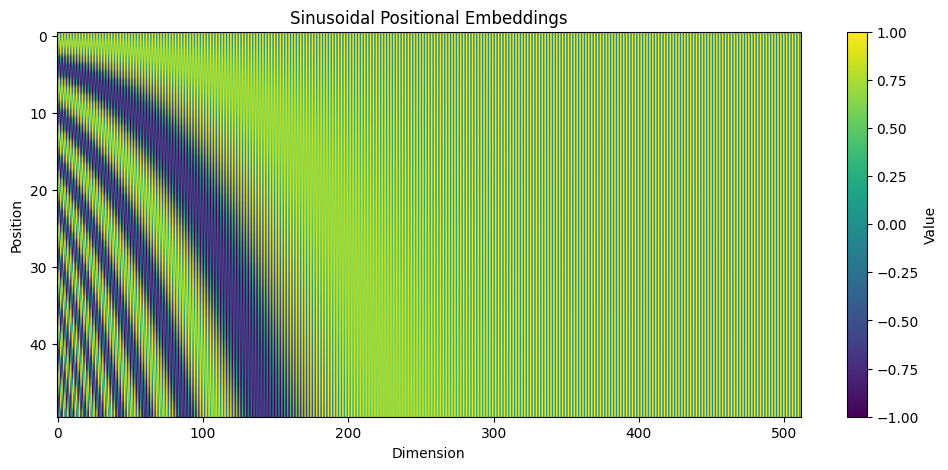

In [4]:
freq_cis = attention_standard.precompute_freqs_cis(512, 50)

freqs_cos =   freq_cis.imag # shape: [50, 256]
freqs_sin = freq_cis.real  # shape: [50, 256]

pos_emb = torch.zeros(50, 512)
pos_emb[:, 0::2] = freqs_cos
pos_emb[:, 1::2] = freqs_sin

plt.figure(figsize=(12, 5))
plt.imshow(pos_emb, aspect='auto', cmap='viridis')
plt.colorbar(label="Value")
plt.xlabel("Dimension")
plt.ylabel("Position")
plt.title("Sinusoidal Positional Embeddings")
plt.show()

Test and change impl that was very close co Lama3. I looked to LIGER tests and found out that they compare to Lama from HF-Transformers. Its impl was using rotation slightly different.
I have modified the impl little bit to follow transformers implementation - I want to have same results as LIGER for fallback when I cannot use it for some reason. 

freqs_cis_sp right after assignment: tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j], device='cuda:0')
Final complex values:
 tensor([[1.0000+0.0000j, 1.0000+0.0000j],
        [0.5403+0.8415j, 0.7318+0.6816j]], device='cuda:0')
whole complex values:
 tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.7318+6.8156e-01j,  0.8460+5.3317e-01j,
          ...,  1.0000+2.3714e-04j,  1.0000+1.7783e-04j,
          1.0000+1.3335e-04j],
        [-0.4161+9.0930e-01j,  0.0709+9.9748e-01j,  0.4315+9.0213e-01j,
          ...,  1.0000+4.7427e-04j,  1.0000+3.5566e-04j,
          1.0000+2.6670e-04j],
        ...,
        [ 0.7877-6.1604e-01j,  0.8723-4.8905e-01j,  0.3831+9.2370e-01j,
          ...,  0.9996+2.9638e-02j,  0.9998+2.2227e-02j,
          0.9999+1.6668e-02j],
        [ 0.9440+3.2999e-01j,  0.9716+2.3663e-01j, -0.1684+9.8572e-01j,
          ...,  0.9996+2

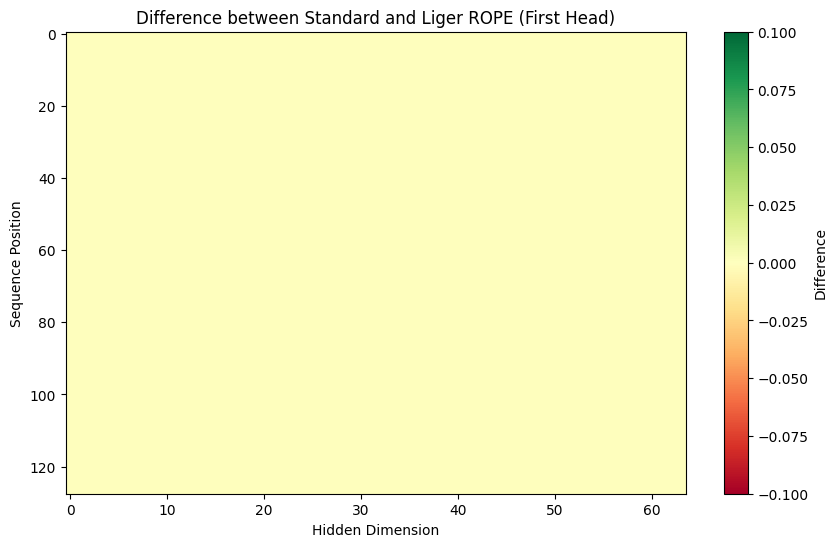

In [5]:

def precompute_freqs_cis(dim: int, end: int, device=None, theta=10000.0):
 # Make sure we're using half dimension since we'll duplicate later

    # This is the key change - use torch.arange(0, dim, 2) instead of just torch.arange
    freqs = 1.0 / (theta ** (torch.arange(0, dim , 2, dtype=torch.float32) / (dim)))

    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [end, dim/2]

    # Convert to complex numbers
    freqs_cis = freqs_cis = torch.complex(torch.cos(freqs), torch.sin(freqs))

    return freqs_cis


def apply_rotary_position_embedding(q, k, freqs_cis_sp):  # [batch,heads,seq,dim]
    """
    Example of reorganizing q, k so that the first half
    is real and the second half is imaginary, then
    doing complex multiply to match Llama's results.
    """
    # Reorder q, k so that their last dim is [half, 2]

    q_ri =  torch.stack((q[..., :q.shape[-1] // 2], q[..., q.shape[-1] // 2:]), dim=-1)
    k_ri =  torch.stack((k[..., :k.shape[-1] // 2], k[..., k.shape[-1] // 2:]), dim=-1)

    # Now interpret as complex
    q_complex = torch.view_as_complex(q_ri)  # shape [batch, heads, seq, half]
    k_complex = torch.view_as_complex(k_ri)

    # freqs_cis should have shape [seq, half] or broadcastable
    # Multiply => apply rotation
    q_rotated = q_complex * freqs_cis_sp   # shape [batch, heads, seq, half]
    k_rotated = k_complex * freqs_cis_sp

    # Convert back to real
    q_ri_out = torch.view_as_real(q_rotated)  # shape [..., half, 2]
    k_ri_out = torch.view_as_real(k_rotated)

    # "Unstack" them so that the last dimension is 2*half = dim
    # which is [real, imag] => cat => [..., dim]
    q_out = torch.cat([q_ri_out[..., 0], q_ri_out[..., 1]], dim=-1)
    k_out = torch.cat([k_ri_out[..., 0], k_ri_out[..., 1]], dim=-1)

    return q_out, k_out

if not torch.cuda.is_available():
    pytest.skip("CUDA required for this test")

device = torch.device('cuda')

# Set seed for reproducibility
torch.manual_seed(42)

# Create small test input
batch_size = 1
seq_len = 128
d_model = 128
num_heads = 2

x = torch.randn(batch_size, seq_len, d_model, device=device)

# Create both configurations
config_standard = GPT2Configuration(block_size=128, d_model=d_model, num_heads=num_heads, use_liger=False)

attention_standard = Attention(config_standard).to(device)
B, S, D = x.size()
head_dim = D // config_standard.num_heads

qkv_bhsd = map(lambda t: t.view(B, S, config_standard.num_heads, head_dim).transpose(1, 2),
                attention_standard.c_attn(x).chunk(3, dim=-1))
q_bhsd, k_bhsd, v_bhsd = qkv_bhsd

freqs_cis_sp = precompute_freqs_cis(
    config_standard.d_model // config_standard.num_heads,
    config_standard.block_size,
    device=device
).to(device)

print("freqs_cis_sp right after assignment:", freqs_cis_sp[0, :5])
print("Final complex values:\n", freqs_cis_sp[:2, :2])
print("whole complex values:\n", freqs_cis_sp)


cos = freqs_cis_sp.real  # [seq, half_dim]
sin = freqs_cis_sp.imag  # [seq, half_dim]

# # # Concatenate to get full dimension
cos = torch.cat([cos, cos], dim=-1)  # [seq, dim]
sin = torch.cat([sin, sin], dim=-1)  # [seq, dim]

# # Add batch dimension
cos = cos.unsqueeze(0)  # [1, seq, dim]
sin = sin.unsqueeze(0)  # [1, seq, dim]

print("After reshape:")
print("q_bhsd shape:", q_bhsd.shape)
print("cos shape:", cos.shape)
print("sin shape:", sin.shape)

q_rope, k_rope = apply_rotary_position_embedding(q_bhsd, k_bhsd, freqs_cis_sp[:S])


l_q_rope, l_k_rope = LigerRopeFunction.apply(
    q_bhsd, k_bhsd,
    cos[:, :S], sin[:, :S],
    None,
    1    # unsqueeze_dim
)

print("q_rope shape:", q_rope.shape)
print("l_q_rope shape:", l_q_rope.shape)
# After getting the outputs, print values at different positions
positions_to_check = [0, 1, 10, 50, 100]  # Check various sequence positions

for pos in positions_to_check:
    print(f"\nPosition {pos}:")
    print("Standard q:", q_rope[0, 0, pos, :5].cpu().detach().numpy())  # First batch, first head, first 5 values
    print("Liger q:", l_q_rope[0, 0, pos, :5].cpu().detach().numpy())
    print("Difference:", torch.abs(q_rope - l_q_rope)[0, 0, pos, :5].cpu().detach().numpy())

# Also print the actual frequency values being used
print("\nFrequency values at these positions:")
for pos in positions_to_check:
    print(f"\nPosition {pos}:")
    print("Complex freq:", freqs_cis_sp[pos, :5])
    print("Real freq:", freqs_cis_sp.real[pos, :5])


# Add this debug code before the ROPE application
print("freqs_cis_sp shape:", freqs_cis_sp.shape)
print("First few values of freqs_cis_sp:")
print(freqs_cis_sp[0, :5])  # First 5 values

# Check the actual complex numbers being used
print("\nFirst few complex numbers:")
print("Real:", freqs_cis_sp.real[0, :5])
print("Imag:", freqs_cis_sp.imag[0, :5])

# Compare outputs
print("\nStandard ROPE output (first position, first head):")
print(q_rope[0, 0, 0, :10].cpu().detach().numpy())  # Show first 10 values

print("\nStandard ROPE output (first position, first head):")
print(k_rope[0, 0, 0, :10].cpu().detach().numpy())  # Show first 10 values

print("\nLiger ROPE output q(first position, first head):")
print(l_q_rope[0, 0, 0, :10].cpu().detach().numpy())  # Show first 10 values

print("\nLiger ROPE output k(first position, first head):")
print(l_k_rope[0, 0, 0, :10].cpu().detach().numpy())  # Show first 10 values

print("\nAbsolute difference between ROPE outputs:")
print(torch.abs(q_rope - l_q_rope).max().item())

print("\nAbsolute difference between ROPE outputs k:")


# Visualize differences
plt.figure(figsize=(10, 6))
diff = (q_rope - l_q_rope)[0, 0].cpu().detach().numpy()  # First batch, first head
plt.imshow(diff, cmap='RdYlGn', aspect='auto')
plt.colorbar(label='Difference')
plt.title('Difference between Standard and Liger ROPE (First Head)')
plt.xlabel('Hidden Dimension')
plt.ylabel('Sequence Position')
plt.show()


Test with both Transformer and LIGER implementations.

`LlamaRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Custom implementation first values:
Cos: tensor([1., 1., 1., 1., 1.], device='cuda:0')
Sin: tensor([0., 0., 0., 0., 0.], device='cuda:0')

LLaMA implementation first values:
Cos: tensor([1., 1., 1., 1., 1.])
Sin: tensor([0., 0., 0., 0., 0.])

Value ranges:
Custom - Cos range: -1.0 to 1.0
Custom - Sin range: -0.9999902248382568 to 0.9999983310699463
LLaMA - Cos range: -1.0 to 1.0
LLaMA - Sin range: -0.9999902248382568 to 0.9999983310699463
Custom implementation first few values:
torch.complex64
tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j], device='cuda:0')

LLaMA implementation first few values:
torch.complex64
tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j], device='cuda:0')
cos shape: torch.Size([1, 128, 64])
sin shape: torch.Size([1, 128, 64])
llama_cos shape: torch.Size([1, 128, 64])
llama_sin shape: torch.Size([1, 128, 64])
Cosine close: True
Sine close: True


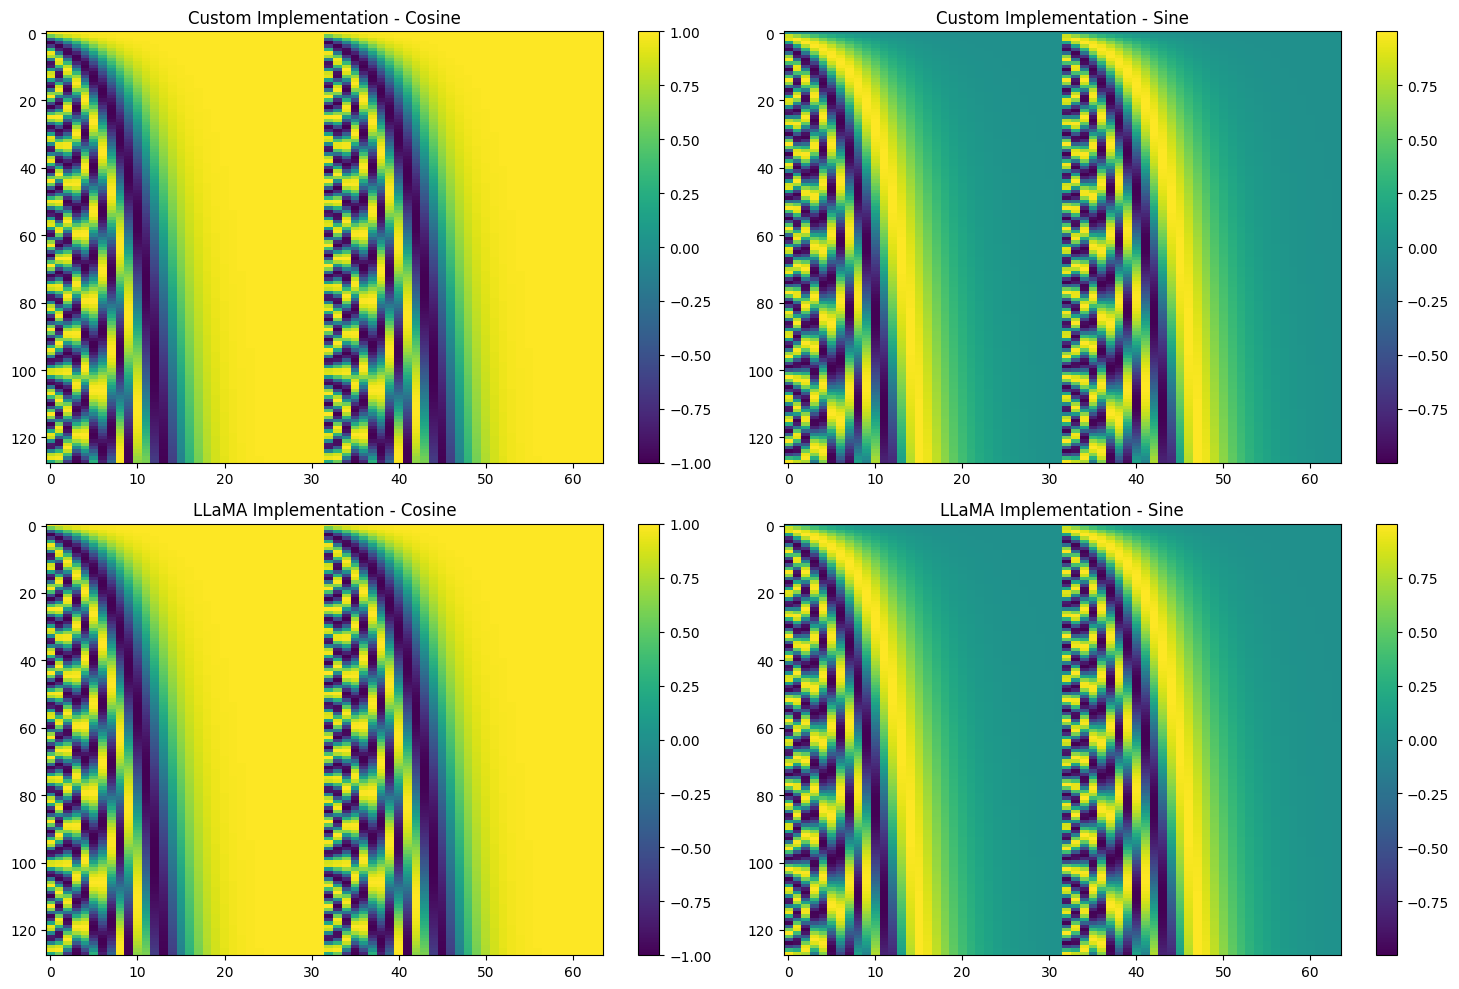

In [6]:
# Debug comparison between implementations
def compare_rope_implementations(head_dim=config_standard.d_model//config_standard.num_heads, seq_len=config_standard.block_size, theta=10000.0):
    # Your current implementation

    freqs_cis_custom = precompute_freqs_cis(
    head_dim,
    seq_len,
    device=device
    ).to(device)


    # LLaMA implementation
    rotary_emb = LlamaRotaryEmbedding(head_dim, base=theta)
    pos_ids = torch.arange(seq_len).unsqueeze(0)
    llama_cos, llama_sin = rotary_emb(x, pos_ids)

    # Print first few values of each
    print("Custom implementation first values:")
    print("Cos:", freqs_cis_custom.real[0, :5])
    print("Sin:", freqs_cis_custom.imag[0, :5])

    print("\nLLaMA implementation first values:")
    print("Cos:", llama_cos[0, 0, :5])
    print("Sin:", llama_sin[0, 0, :5])

    # Compare distributions
    print("\nValue ranges:")
    print("Custom - Cos range:", freqs_cis_custom.real.min().item(), "to", freqs_cis_custom.real.max().item())
    print("Custom - Sin range:", freqs_cis_custom.imag.min().item(), "to", freqs_cis_custom.imag.max().item())
    print("LLaMA - Cos range:", llama_cos.min().item(), "to", llama_cos.max().item())
    print("LLaMA - Sin range:", llama_sin.min().item(), "to", llama_sin.max().item())

    print("Custom implementation first few values:")
    print(freqs_cis_custom[0, :5].dtype)
    print(freqs_cis_custom[0, :5])

    print("\nLLaMA implementation first few values:")
    print(freqs_cis_custom[0, :5].dtype)
    print(freqs_cis_custom[0, :5])
    return freqs_cis_custom, llama_cos, llama_sin

# Run comparison
freqs_cis_custom, llama_cos, llama_sin = compare_rope_implementations()

print("cos shape:", cos.shape)
print("sin shape:", sin.shape)
print("llama_cos shape:", llama_cos.shape)
print("llama_sin shape:", llama_sin.shape)

cos_close = torch.allclose(llama_cos[0].cpu().detach(), cos.cpu().detach(), rtol=1e-5, atol=1e-8)
sin_close = torch.allclose(llama_sin[0].cpu().detach(), sin.cpu().detach(), rtol=1e-5, atol=1e-8)

print("Cosine close:", cos_close)
print("Sine close:", sin_close)

pos_ids = torch.arange(seq_len, device=device, dtype=torch.long).unsqueeze(0)

llama_q, llama_k = apply_rotary_pos_emb(q_bhsd, k_bhsd,llama_cos.to(device), llama_sin.to(device), pos_ids)

# Visualize both implementations
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(cos.cpu().detach().numpy()[0], aspect='auto')
plt.title('Custom Implementation - Cosine')
plt.colorbar()

plt.subplot(222)
plt.imshow(sin.cpu().detach().numpy()[0], aspect='auto')
plt.title('Custom Implementation - Sine')
plt.colorbar()

plt.subplot(223)
plt.imshow(llama_cos[0].cpu(), aspect='auto')
plt.title('LLaMA Implementation - Cosine')
plt.colorbar()

plt.subplot(224)
plt.imshow(llama_sin[0].cpu(), aspect='auto')
plt.title('LLaMA Implementation - Sine')
plt.colorbar()

plt.tight_layout()
plt.show()

assert torch.allclose(llama_q.cpu().detach(), l_q_rope.cpu().detach(), atol=1e-5, rtol=1e-5)
assert torch.allclose(llama_k.cpu().detach(), l_k_rope.cpu().detach(), atol=1e-5, rtol=1e-5)
assert torch.allclose(llama_q.cpu().detach(), q_rope.cpu().detach(), atol=1e-5, rtol=1e-5)
assert torch.allclose(llama_k.cpu().detach(), k_rope.cpu().detach(), atol=1e-5, rtol=1e-5)

Finally use attention with both implementations and compare outputs. They should be the same. Make sure to copy weights of linear layers in attention so they are the same. Also cannot copy everything because of buffers.

In [ ]:

if not torch.cuda.is_available():
    pytest.skip("CUDA required for this test")

device = torch.device('cuda')

# Set seed for reproducibility
torch.manual_seed(42)

# Create small test input
batch_size = 1
seq_len = 128
d_model = 256
num_heads = 2

x = torch.randn(batch_size, seq_len, d_model, device=device)

# Create both configurations
config_standard = GPT2Configuration(block_size=seq_len, d_model=d_model, num_heads=num_heads, use_liger=False)

# Create the first attention module
attention_standard = Attention(config_standard).to(device)

# Create new config and attention for Liger
config_liger = GPT2Configuration(block_size=seq_len, d_model=d_model, num_heads=num_heads, use_liger=True)
attention_liger = Attention(config_liger).to(device)


# Create attention modules
attention_standard = Attention(config_standard).to(device)
attention_liger = Attention(config_liger).to(device)

# Copy only the trainable parameters, not the buffers
liger_state_dict = attention_liger.state_dict()
standard_state_dict = attention_standard.state_dict()

# Copy only the weights of linear layers, excluding the position embedding buffers
for key in ['c_attn.weight', 'c_attn.bias', 'c_proj.weight', 'c_proj.bias']:
    if key in standard_state_dict:
        liger_state_dict[key].copy_(standard_state_dict[key])

# Get outputs
with torch.no_grad():
    output_standard = attention_standard(x)
    output_liger = attention_liger(x)

# Print first sequence position outputs for comparison
print("\nStandard mode output (first position):")
print(output_standard[0, 0, :].cpu().numpy())

print("\nLiger mode output (first position):")
print(output_liger[0, 0, :].cpu().numpy())

print("\nAbsolute difference between outputs (first position):")
print(torch.abs(output_standard - output_liger)[0, 0, :].cpu().numpy())

# Print some statistics
print("\nStatistics:")
print(f"Standard output - Mean: {output_standard.mean():.4f}, Std: {output_standard.std():.4f}")
print(f"Liger output - Mean: {output_liger.mean():.4f}, Std: {output_liger.std():.4f}")
print(f"Max absolute difference: {torch.abs(output_standard - output_liger).max():.4f}")



Standard mode output (first position):
[ 0.06266034  0.24272203 -0.25877804  0.34574878 -0.13211827  0.6081396
  0.29244232  0.10689025 -0.2039909  -0.13185805  0.37519184 -0.12247106
 -0.19169259 -0.3802536   0.01781144  0.30294955 -0.07405922 -0.41130993
  0.56350976  0.07054152  0.42062414 -0.28638372 -0.05553218  0.22830501
  0.22641124 -0.20078996 -0.2569874   0.3528805  -0.2794321   0.14821938
  0.11293093  0.01754425  0.19284637 -0.41320512  0.03847726  0.09926527
  0.77943003 -0.41461846 -0.11234714 -0.30055    -0.46708497  0.65006924
  0.08883919 -0.46656802 -0.18055189 -0.12513737 -0.05859032  0.06280581
 -0.41116363 -0.6710171  -0.23844367 -0.08972555  0.5636399   0.07494238
 -0.10382426 -0.1045849  -0.26101163  0.05317399 -0.17181718 -0.00613449
  0.43959597  0.03745178  0.04050643  0.08169558  0.13856661 -0.08402141
  0.636658    0.2809653   0.15000379 -0.42338774 -0.07738232  0.12486714
  0.20609067 -0.5494611  -0.0691212   0.05531323  0.03294194 -0.22459838
  0.2983951 

### Voila!

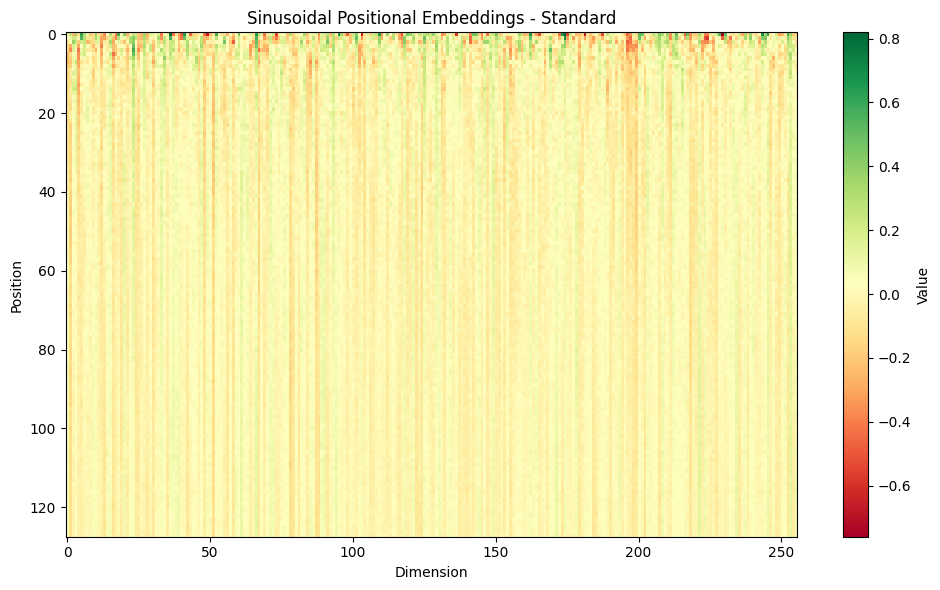

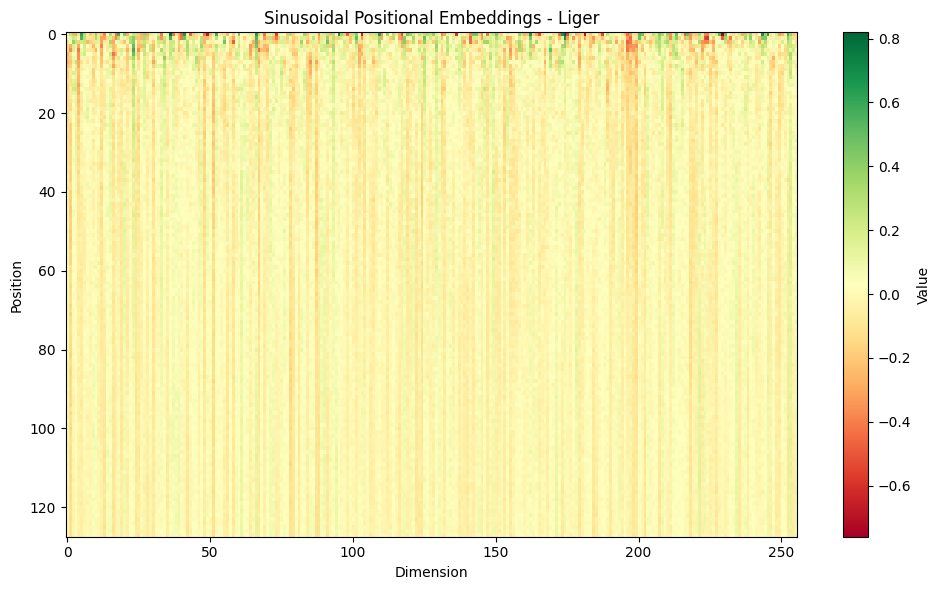

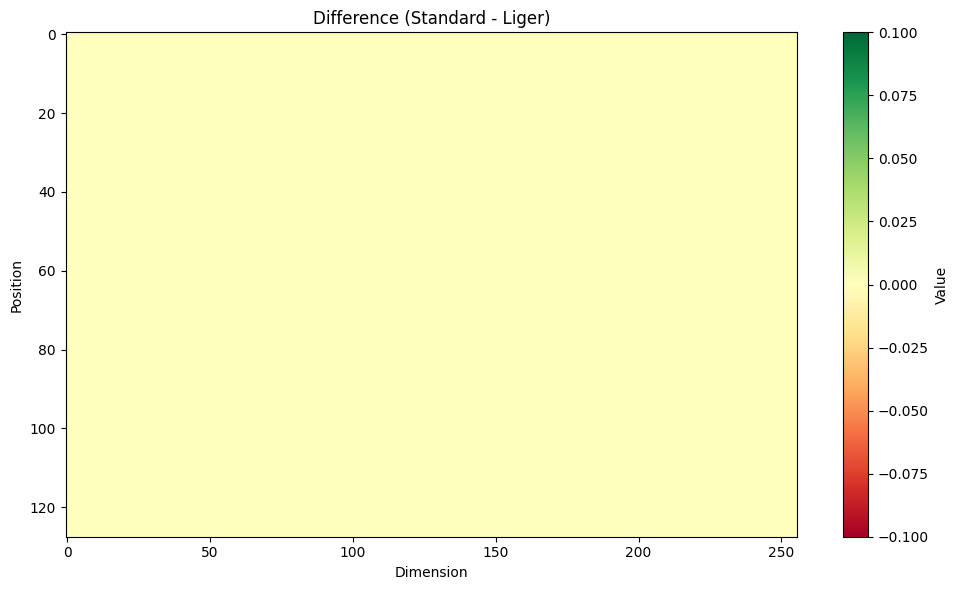

In [ ]:
# Keep your existing setup code, but just change the visualization part:

# Visualize the outputs
plt.figure(figsize=(10, 6))
plt.imshow(output_standard[0].cpu().numpy(),
           cmap='RdYlGn',
           aspect='auto',
           interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Sinusoidal Positional Embeddings - Standard')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(output_liger[0].cpu().numpy(),
           cmap='RdYlGn',
           aspect='auto',
           interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Sinusoidal Positional Embeddings - Liger')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

# Difference plot
plt.figure(figsize=(10, 6))
diff = output_standard[0].cpu().numpy() - output_liger[0].cpu().numpy()
plt.imshow(diff,
           cmap='RdYlGn',
           aspect='auto',
           interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Difference (Standard - Liger)')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()